# #1 Create input data for MOFA

### #1.1 Import numerical and categorical data

In [14]:
import pandas as pd
df_num = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/6_clustering/df_all_numerical.csv', sep=',')
l_num = list(df_num.columns)
df_cat = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/6_clustering/df_all_categorical.csv', sep=',')
l_cat = list(df_cat.columns)
l_cat = [i for i in l_cat if i not in ['PHYSICIAN']]

df_imp = df_cat.merge(df_num, left_index=True, right_index=True)

df_imp['sample'] = range(len(df_imp))
df_imp.head()

,RF,aCCP,aSSA,ENA,ANA,Sex,Zwelling_Elleboog L,Zwelling_IP links,Zwelling_IP rechts,Zwelling_IP voet links,...,MCV,BSE,Trom,Age,Big joints,Small joints,Symmetrical joints,SJC,TJC,sample
0,1,1,0,0,0,0,0.0,0.0,0.0,0.0,...,84.0,22,270,70,2,18,2,18,18,0
1,0,0,0,0,0,0,0.0,1.0,0.0,0.0,...,88.0,9,249,55,2,21,2,7,22,1
2,2,2,2,2,2,1,0.0,0.0,0.0,0.0,...,94.0,13,202,47,2,1,1,1,3,2
3,1,1,0,0,0,1,0.0,1.0,0.0,0.0,...,86.0,17,337,51,2,4,1,4,6,3
4,1,1,0,0,0,0,0.0,0.0,1.0,0.0,...,91.0,48,309,65,1,8,1,8,7,4


### #1.2 Create metadata

In [ ]:
columns = l_num[:14]
columns.extend(l_cat)
columns.extend(['sample'])
df_imp[columns].to_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/6_clustering/df_metadata.csv', index=False)

### #1.3 Convert our data to MOFA dataframe (WIDE to LONG transformation)

In [8]:
import pandas as pd
import re

def is_ascii(mystring):
    try:
        mystring.encode('ascii')
    except UnicodeEncodeError:
        return False
    else:
        return True

def filter_forbidden_char(l_val):
    d_trans = {}
    for col_name in l_val:
        new_col_name = None
        if 'Ã«' in col_name:
            new_col_name = re.sub('Ã«', 'e', col_name)
        if 'ï' in col_name:
            new_col_name = re.sub('ï', 'i', col_name)
        if 'ë' in col_name:
            new_col_name = re.sub('ë', 'e', col_name)
        if new_col_name != None:
            d_trans[col_name] = new_col_name
    return d_trans


df_a = pd.read_csv('../data/6_clustering/df_mannequin_categorical_ohe.csv')
df_b = pd.read_csv('../data/6_clustering/df_mannequin_counts_normalized_scaling.csv') # INDIVIDUAL_mannequin_counts_normalized_scaling.csv
df_c = pd.read_csv('../data/6_clustering/df_tfidf_rheum.csv') # maybe turn into counts as well?
df_c = df_c.rename(columns=filter_forbidden_char(df_c.columns))
df_c = df_c.groupby(axis=1, level=0).sum()
df_d = pd.read_csv('../data/6_clustering/df_tfidf_radio.csv')
df_d = df_d.fillna(0) #  for some we can't find radiology?/
df_d = df_d.rename(columns=filter_forbidden_char(df_d.columns))
df_d = df_d.groupby(axis=1, level=0).sum()

df_e = pd.read_csv('../data/6_clustering/df_lab_serology.csv')
df_f = pd.read_csv('../data/6_clustering/df_lab_numerical.csv')
l_view = ['mannequin_ohe', 'mannequin_counts', 'serology',  'lab'] # 'physician_notes',  'radio_notes',
d_view = { 'mannequin_ohe': df_a, 'mannequin_counts'  : df_b, 'physician_notes' : df_c, 'radio_notes' : df_d, 'serology' : df_e, 'lab' : df_f}


df_mofa = pd.DataFrame(columns=['sample', 'feature', 'value', 'view'])

for view in l_view:
    print(view)
    data = d_view[view]
    cnt = 0
    for ix, feature in enumerate(data):
        try:
            new_df = pd.DataFrame({'sample': list(range(len(data[feature]))), 'feature': feature, 'value': data[feature], 'view': view})
        except:
            print(len(data[feature]), data[feature], data)
        df_mofa = pd.concat([df_mofa, new_df])
        if len(data.columns) > 9:
            if ix % round(len(data.columns)/10) == 0:
                print("%s/%s" % (str(ix/round(len(data.columns)/10)), str(10)))
df_mofa.to_csv('../data/6_clustering/df_all_MOVA_no_txt.csv', index=False, sep=',')
df_mofa.head()

mannequin_ohe
0.0/10
1.0/10
2.0/10
3.0/10
4.0/10
5.0/10
6.0/10
7.0/10
8.0/10
9.0/10
mannequin_counts
serology
0.0/10
1.0/10
2.0/10
3.0/10
4.0/10
5.0/10
6.0/10
7.0/10
lab


,sample,feature,value,view
0,0,Zwelling_Elleboog L_negative,1.0,mannequin_ohe
1,1,Zwelling_Elleboog L_negative,1.0,mannequin_ohe
2,2,Zwelling_Elleboog L_negative,1.0,mannequin_ohe
3,3,Zwelling_Elleboog L_negative,1.0,mannequin_ohe
4,4,Zwelling_Elleboog L_negative,1.0,mannequin_ohe


# #2 Run MOFA version 2

Open RA_clustering/src/3_clustering_scripts/mofa_ehr.Rmd in Rstudio

# #3 Create MOFA interactive plot

### #3.1 Import latent feature space (mofa_factors.csv) and metadata

In [19]:
import pandas as pd

# Latent feature space (a.k.a. Factors from MOFA)
Z = pd.read_csv('../results/embedding/mofa_factors.csv')

metadata = pd.read_csv('../data/6_clustering/df_metadata.csv')

# add HIX-ids and prediction
df_extra_inf = pd.read_csv('../data/6_clustering/df_HIX_PATNR.csv')
metadata = metadata.merge(df_extra_inf, on='sample')

# Combine with response data
df_response = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/8_final/SummaryResponseTable.csv', sep=';')
metadata = metadata.merge(df_response,left_on='patnr', right_on='patnr')
metadata = metadata.fillna(0)
l_cat.extend(['Treatment', 'FinalTreatment', 'Treatment_shift'])

Z = Z.iloc[list(metadata['sample'].values)]
Z = Z.reset_index(drop=True)

### 3.2 Apply PhenoGraph clustering & create interactive 2d embedding

In [21]:
import pandas as pd
import phenograph
import sys
sys.path.append(r'../src/1_emr_scripts')
import importlib as imp
import Visualization as func
import umap 
from sklearn.manifold import TSNE

imp.reload(func)

# Factors
fit1 = umap.UMAP(random_state=210721,metric='euclidean').fit(Z.values).embedding_
#fit1 = TSNE(random_state=13072021, n_components=2).fit_transform(Z.values)

# Weights
# W_lab = pd.read_csv('../results/embedding/mofa_lab_weights.csv') 
# W_man_counts = pd.read_csv('../results/embedding/mofa_mannequin_counts_weights.csv') 
# W_man_ohe = pd.read_csv('../results/embedding/mofa_mannequin_ohe_weights.csv') 
# W_serology = pd.read_csv('../results/embedding/mofa_serology_weights.csv') 

label, _, _ = phenograph.cluster(Z.values, random_state=210721, k=130) 

metadata['PhenoGraph_clusters'] = label

# Get more insight into Mannequin by visualizing the ratios
metadata['Swollen ratio'] = metadata['SJC'] / (metadata['SJC']+metadata['TJC'])
metadata['Swollen ratio'] = metadata['Swollen ratio'].fillna(0)

metadata['Tender ratio'] = metadata['TJC'] / (metadata['SJC']+metadata['TJC'])
metadata['Tender ratio'] = metadata['Tender ratio'].fillna(0)

metadata['Big ratio'] = metadata['Big joints'] / (metadata['TJC']+metadata['SJC'])
metadata['Big ratio'] = metadata['Big ratio'].fillna(0)

metadata['Small ratio'] = metadata['Small joints'] / (metadata['TJC']+metadata['SJC'])
metadata['Small ratio'] =metadata['Small ratio'].fillna(0)

metadata['Symmetrical ratio'] = metadata['Symmetrical joints'] / (metadata['TJC']+metadata['SJC'])
metadata['Symmetrical ratio'] = metadata['Symmetrical ratio'].fillna(0)
metadata = pd.concat([metadata, Z], axis=1) # add latent factors


func.visualize_umap_bokeh(fit1, metadata, list(metadata.columns), l_binary=l_cat, patient_id='sample', cluster_id='PhenoGraph_clusters', title='MOFA_without_notes')

# Save final dataset
metadata.to_csv('../data/8_final/all_data_Mofa_clustering2.csv', index=False)


Finding 130 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.052480220794677734 seconds
Jaccard graph constructed in 9.801099061965942 seconds
Wrote graph to binary file in 0.745938777923584 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.346176
Louvain completed 21 runs in 2.075713872909546 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 14.660631895065308 seconds
989 989
0 []

UMAP figure saved under location: TSNE/Baseline_umap_MOFA_without_notes.html


In [44]:
from collections import Counter
z = metadata['PhenoGraph_clusters']
Counter(z)

Counter({0: 400, 1: 233, 2: 213, 3: 143})

# #4 Finetuning k from Phenograph

Prior to applying phenograph it is important that you selected the optimal k

We will create a heatmap that depicts the similarity between iterations of Phenograph with different k's to select the most optimal k.

In [33]:
from scipy import sparse
import numpy as np
import phenograph
# define a function that will give us the relevant output for the input k
def calc_cluster_characteristics(k, embedding, seed):
    results = pd.Series(dtype = 'float64')
    results['k'] = k
    results['communities'], results['graph'], results['Q'] = phenograph.cluster(embedding, k=k,  seed=seed) # random_state=seed,
    results['components'], _ = sparse.csgraph.connected_components(results['graph'], directed = False)
    return results

seed=210721
ks = np.arange(10, 151, 10) #5 # This is the range of k values we will look at
cluster_chars_list = [calc_cluster_characteristics(k, Z.values, seed) for k in ks]
cluster_characteristics = pd.concat(cluster_chars_list, axis = 1).transpose()

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.025044918060302734 seconds
Jaccard graph constructed in 0.5765786170959473 seconds
Wrote graph to binary file in 0.032798051834106445 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.695276
After 2 runs, maximum modularity is Q = 0.697223
Louvain completed 22 runs in 1.2232027053833008 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 2.470460891723633 seconds
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.024729013442993164 seconds
Jaccard graph constructed in 0.8072638511657715 seconds
Wrote graph to binary file in 0.06276917457580566 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.583136
After 3 runs, maximum modularity is Q = 0.585719
Louvain completed 23 runs in 1.2612171173095703 seconds
Sorting communities by size, please wait

PhenoGraph completed in 12.058768272399902 seconds


## #4.1 Q-modularity
Conclusion: based on this figure (and the continuous increment) we know this data is very homogenous and not really modular. Which is also what we observe on the T-SNE/ UMAP -> patients are laid out over a continuum rather than into modules.

read: https://github.com/dpeerlab/PhenoGraph/blob/master/examples/tutorial_pbmc3k.ipynb

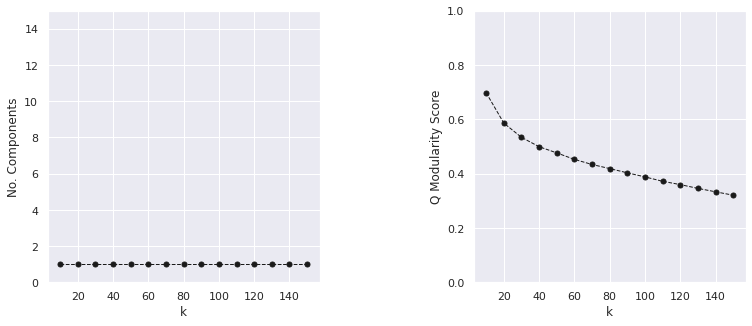

In [34]:
import matplotlib.pyplot as plt
k = cluster_characteristics['k']
no_components = cluster_characteristics['components']
Q = cluster_characteristics['Q']

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 5))
ax1.set_box_aspect(1)
ax1.plot(k, no_components, color='k', marker='o', linestyle='dashed', linewidth=1, markersize=5, )
ax1.set_xlabel('k')
ax1.set_ylabel('No. Components')
ax1.set_ylim(0, 15)

ax2.set_box_aspect(1)
ax2.plot(k, Q, color='k', marker='o', linestyle='dashed', linewidth=1, markersize=5)
ax2.set_xlabel('k')
ax2.set_ylabel('Q Modularity Score')
ax2.set_ylim(0, 1)

plt.show()
plt.close()

## #4.2 Rand Index (which K should we use?)

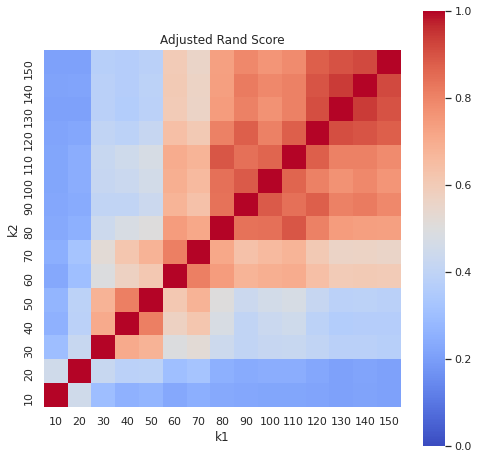

In [35]:
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
n = len(ks)
Rand_indices = pd.DataFrame(np.zeros((n,n)), index = ks, columns = ks)

Rand_indices.index.name = 'k1'
Rand_indices.columns.name = 'k2'

for i in range(n):
    for j in range(n):
        Rand_indices.iloc[i, j] = adjusted_rand_score(
            cluster_characteristics['communities'][i], 
            cluster_characteristics['communities'][j]
        )
        
plt.figure(figsize = (8,8))
sns.heatmap(Rand_indices, cmap=('coolwarm'), square=True, vmin=0, vmax=1).invert_yaxis()
sns.set(font_scale=1)
plt.xlabel('k1')
plt.ylabel('k2')
plt.title('Adjusted Rand Score')
plt.show()
plt.close()

## #4.3 Robustness over multiple iterations
In less-structured data you would expect a lot of variety in the clustering over multiple iterations. Or data describing patients which lie on a continuum you might find more substantial changes between runs of the PhenoGraph algorithm. Hence, we show the cluster assignments over multiple runs of PhenoGraph, with unchanged parameter settings.

In [38]:
k = 130 # k to use
n_runs = 5 # number of times to run PhenoGraph with unchanged parameters

cluster_cols = []

for i in range(n_runs):
    communities, graph, Q = phenograph.cluster(Z.values, k=k)
    cluster_name = 'PhenoGraph_k_' + str(k) + '_run_' + str(i)
    metadata[cluster_name] = pd.Categorical(communities)
    cluster_cols.append(cluster_name)

Finding 130 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.03905439376831055 seconds
Jaccard graph constructed in 5.884339332580566 seconds
Wrote graph to binary file in 1.4364488124847412 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.344282
After 3 runs, maximum modularity is Q = 0.345726
Louvain completed 23 runs in 3.541114330291748 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 11.520680904388428 seconds
Finding 130 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.03378653526306152 seconds
Jaccard graph constructed in 5.832801818847656 seconds
Wrote graph to binary file in 0.5212404727935791 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.342473
After 2 runs, maximum modularity is Q = 0.344406
After 5 runs, maximum modularity is Q = 0.345805
Louvain completed 25 runs in 2.0002810955047607 seco

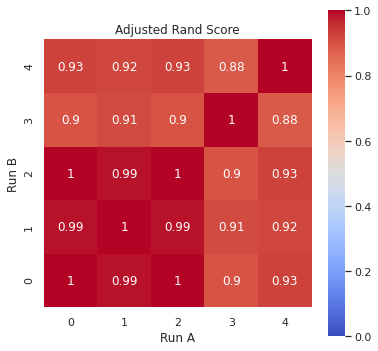

In [39]:
Rand_indices_unchanged_params = pd.DataFrame(np.zeros((n_runs,n_runs)))

for i in range(n_runs):
    for j in range(n_runs):
        Rand_indices_unchanged_params.iloc[i, j] = adjusted_rand_score(
            metadata[cluster_cols[i]], 
            metadata[cluster_cols[j]]
        )
        
plt.figure(figsize = (6,6))
sns.heatmap(Rand_indices_unchanged_params, cmap=('coolwarm'), square=True, vmin=0, vmax=1, annot = True).invert_yaxis()
sns.set(font_scale=1)
plt.xlabel('Run A')
plt.ylabel('Run B')
plt.title('Adjusted Rand Score')
plt.show()
plt.close()


# 5. Survival analysis

### #5.1 Import cohorts with treatment information

In [1]:
import pandas as pd

df_response = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/8_final/SummaryResponseTable.csv', sep=';')
df_response = df_response[df_response['MTX-starter']==True]
df_response['Cluster'] = df_response['Cluster'] + 1

# create dummy variables
just_dummies = pd.get_dummies(df_response['Cluster'])

df_response = pd.concat([df_response, just_dummies], axis=1)   
df_response = df_response.rename(columns={1: 'Cluster1', 2: 'Cluster2', 3: 'Cluster3', 4: 'Cluster4'})

### #5.2 Create variables for survival analysis (time and event)

In [2]:
import numpy as np

def getFollowUp(row, max_followup=None):
    if row['firstDateSwitch'] == row['firstDateSwitch']:
        if max_followup!= None :
            if row['firstDateSwitch'] > max_followup :
                return max_followup
            else :
                return row['firstDateSwitch']
        else :
            return row['firstDateSwitch']
    else :
        if max_followup!= None :
            if row['totalFollowUp'] > max_followup :
                return max_followup
            else :
                return row['totalFollowUp']
        else :
            return row['totalFollowUp'] #FollowUp
    
def setStatus(row, max_followup=None):
    if row['firstDateSwitch'] == row['firstDateSwitch']:
        if max_followup!= None :
            if row['firstDateSwitch'] > max_followup:
                return False
            else :
                return True
        else :
            return True
    else :
        return False


df_response['time'] = df_response.apply(lambda x: getFollowUp(x, max_followup=None), axis=1)
df_response['event'] = df_response.apply(lambda x: setStatus(x, max_followup=None), axis=1)


### #5.3 Render Kaplan Meier curves

Patients that stay with treatment in cluster 1: 0.61 292
Patients that stay with treatment in cluster 2: 0.74 137
Patients that stay with treatment in cluster 3: 0.57 159
Patients that stay with treatment in cluster 4: 0.78 97


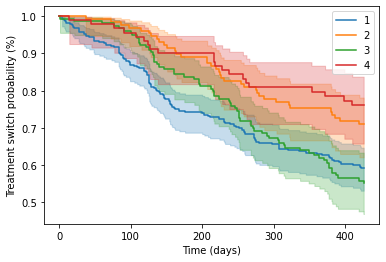

In [3]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for name, grouped_df in df_response.groupby('Cluster'):
    kmf.fit(grouped_df["time"], grouped_df["event"], label=name, timeline=range(0, 365+62, 1)) # , timeline=range(0, 365+62, 1)
    kmf.plot_survival_function(ax=ax)
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Treatment switch probability (%)')
    # calculate final patients that stay with baseline by hand (positive control)
    final = (len(df_response[((df_response['event']==True) & (df_response['Cluster']==name) & (df_response['time']>365+62))]) + len(df_response[((df_response['event']==False) & (df_response['Cluster']==name))]))/len(df_response[((df_response['Cluster']==name))])
    print('Patients that stay with treatment in cluster %s: %.2f' % (name, final), len(df_response[((df_response['Cluster']==name))]))
    #print()

#### #5.3.1 Curves for entire followup

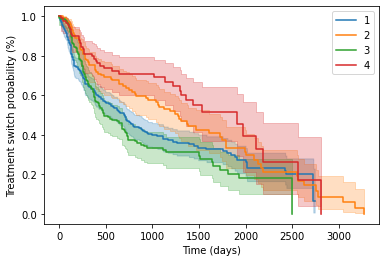

In [45]:
from collections import Counter
import matplotlib.pyplot as plt
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for name, grouped_df in df_response.groupby('Cluster'):
    kmf.fit(grouped_df["time"], grouped_df["event"], label=name) # , timeline=range(0, 3000, 1) timeline=range(0, 3000)
    #print(Counter(grouped_df["time"]))
    kmf.plot_survival_function(ax=ax)
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Treatment switch probability (%)')

#### #5.3.2 Check how many patients per cluster

In [25]:
#cluster_idx = 2
for cluster_idx in range(1,5):
    print(cluster_idx, len(df_response[df_response['Cluster']==cluster_idx]), df_response[df_response['Cluster']==cluster_idx]['Treatment_shift'].mean())

1 292 0.6095890410958904
2 137 0.583941605839416
3 159 0.6729559748427673
4 97 0.4020618556701031


#### #5.3.3 Calculate logrank test (Warning: COX is superior) 

In [3]:
#df_response['Treatment_shift']
from lifelines.statistics import multivariate_logrank_test
result = multivariate_logrank_test(df_response['time'], df_response['Cluster'], df_response['event'])
print(result.test_statistic,result.p_value, result.print_summary())

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          21.67 <0.005     13.67

21.668070708364105 7.647131441880404e-05 None


### #5.4 Perform Cox Regression analysis

<lifelines.CoxPHFitter: fitted with 661 total observations, 269 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 661
number of events observed = 392
   partial log-likelihood = -2237.86
         time fit was run = 2021-08-16 10:47:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Cluster3    0.16       1.18       0.11            -0.06             0.39                 0.94                 1.47

             z    p   -log2(p)
covariate                     
Cluster3  1.44 0.15       2.75
---
Concordance = 0.52
Partial AIC = 4477.71
log-likelihood ratio test = 2.03 on 1 df
-log2(p) of ll-ratio test = 2.70

<AxesSubplot:xlabel='log(HR) (95% CI)'>

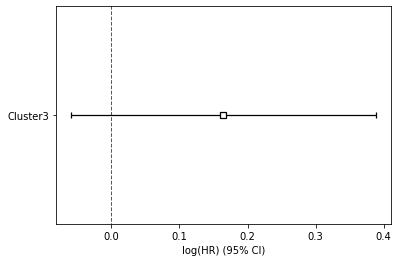

In [7]:
from lifelines import CoxPHFitter

FOLLOWUP=2500

cph = CoxPHFitter()
cph.fit(df_response[df_response['time']<FOLLOWUP][['time', 'event', 'Cluster3']], duration_col='time', event_col='event')

#cph.plot_partial_effects_on_outcome(covariates='Cluster', values=[0, 1, 2, 3], cmap='coolwarm')
cph.print_summary()  # access the individual results using cph.summary

cph.plot() # plot # age, ht, hb, accp, rf, 

#### #5.4.1 Check assumptions with Schoenfeld residual plots

The ``p_value_threshold`` is set at 0.5. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



/exports/reum/tdmaarseveen/convae_architecture/envs/lib/python3.8/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 661 total observations, 268 right-censored observations>
         test_name = proportional_hazard_test

---
              test_statistic    p  -log2(p)
Cluster km              1.80 0.18      2.48
        rank            2.26 0.13      2.92



1. Variable 'Cluster' failed the non-proportional test: p-value is 0.1325.

   Advice: with so few unique values (only 4), you can include `strata=['Cluster', ...]` in the call
in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[[<AxesSubplot:xlabel='rank-transformed time\n(p=0.1325)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.1798)'>]]

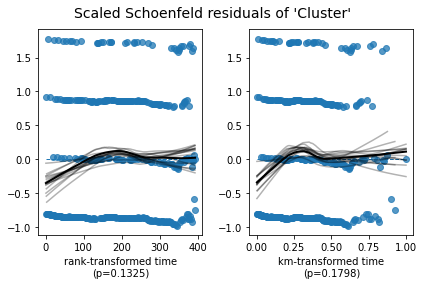

In [17]:
cph.check_assumptions(df_response[df_response['time']<2500][['time', 'event', 'Cluster']],  p_value_threshold=0.5, show_plots=True)

<AxesSubplot:xlabel='HR (95% CI)'>

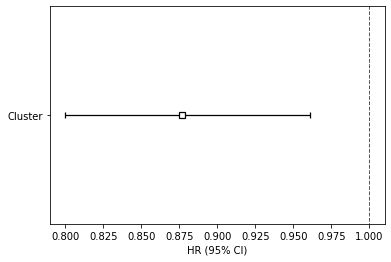

In [203]:
cph.plot(hazard_ratios=True)

# 6. Unused steps

### #6.1 Calculate ranked Scope Pervasion (RSP) [UNUSED]

In [117]:

def get_top_features(cluster_id=0, top=None):
    df_text_features = pd.DataFrame(df_imp[df_imp['PhenoGraph_clusters']==cluster_id][l_num[14:]].sum(axis=0).sort_values(ascending=False))
    df_text_features = df_text_features.reset_index()
    df_text_features = df_text_features.rename(columns={'index' : 'feature', 0: 'prevalence'})
    #print(df_text_features.head(top))
    if top != None:
        return df_text_features['feature'].head(top).values
    else :
        return df_text_features['feature'].values

cluster_id = 6
n_clusters = len(df_imp['PhenoGraph_clusters'].unique())

rsp_list = []
feature_list = []
for index, phe in enumerate(get_top_features(cluster_id=6, top=100)):
    rsp = 0
    for i in range(n_clusters):
        pi = np.where(get_top_features(cluster_id=1) == phe)[0][0]
        rsp += (1 - 1/len(df_imp[l_num[14:]].columns)) * (pi - 1)
    rsp_list.append(rsp)
    feature_list.append(phe)

df_text_features = pd.DataFrame({'feature' : feature_list, 'RSP_weight' : rsp_list})
df_text_features = df_text_features.sort_values(by='RSP_weight', ascending=False) # .head(10)
df_text_features.to_csv('../results/feature_importance/cluster_%s.csv' % (cluster_id))

In [ ]:
cluster_id = 6
df_text_features.to_csv('results/feature_importance/cluster_%s' % (cluster_id))

### #6.2 MUSE clustermap

/home/tdmaarseveen/.conda/envs/ra_clustering2/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/tdmaarseveen/.conda/envs/ra_clustering2/lib/python3.8/site-packages/seaborn/matrix.py:629: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


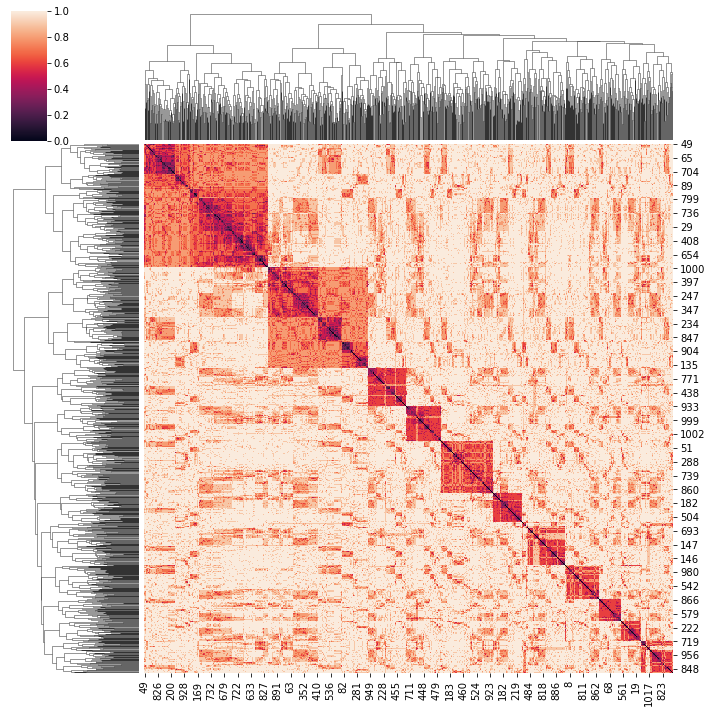

In [35]:
import seaborn as sns
g = sns.clustermap(df_co_occurence)

### 6.3 Project datapoints on each unique factor combination

In [ ]:
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import pandas as pd

df_cluster = pd.read_csv('../data/8_final/all_data_Mofa_clustering2.csv')
df_cluster['PhenoGraph_clusters'] = df_cluster['PhenoGraph_clusters'] + 1

total_pcs = 19
pc_combinations = [i for i in itertools.combinations(range(1,total_pcs+1), 2)]
for i, j in pc_combinations:
    g =sns.scatterplot(x="single_group.Factor%s" % (i), y="single_group.Factor%s" % (j),
                  hue="PhenoGraph_clusters",palette=['green','orange', 'dodgerblue','red'],
                  data=df_cluster);

    plt.subplots_adjust(bottom=0.4)
    plt.tight_layout()
    plt.savefig('/exports/reum/tdmaarseveen/RA_Clustering/figures/3_clustering/ClusterSpace_factor%s_vs_%s.png' % (i, j))
    plt.clf()
    print('plot created')